Config

In [2]:
# TRAINING SETTINGS
NUM_EPOCHS = 5


# LEARNING RATE SETTINGS
BASE_LR = 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 18 # set the number of classes in your dataset
DATA_DIR = 'biased_cars_reorg' # to run with the sample dataset, just set to 'hymenoptera_data'


# DATALOADER PROPERTIES
BATCH_SIZE = 32


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
GPU_MODE = 0 # set to 1 if want to run on gpu.


Imports

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
import pandas as pd
import shutil

import torchvision

Load Labels

In [73]:
data = pd.read_pickle('../../../Downloads/att_dict_simplified.p')


Reorganize folder

In [5]:
root = '../../../Downloads'

# Define the paths
original_dataset_dir = 'biased_cars_1'
new_dataset_dir = 'biased_cars_reorg'

# Classes
classes = [i for i in range(18)]

# Function to create directory if it doesn't exist
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

# Create new dataset structure
create_dir(new_dataset_dir)
for phase in ['train', 'val']:
  for class_i in classes:
    create_dir(os.path.join(new_dataset_dir, phase, str(class_i)))

# print(os.path.join(root, original_dataset_dir, 'BLUE_CARS_9_SCALE_4_ROTATION', phase, 'images'))
# Function to copy files to new structure
def reorganize_dataset(phase):
  subfolders = os.listdir(os.path.join(root, original_dataset_dir))
  for (key, value) in data.items():
      for sub_dir in subfolders:
          images = os.listdir(os.path.join(root, original_dataset_dir, sub_dir, phase, 'images'))
          if key in images:
              shutil.copy(os.path.join(root, original_dataset_dir, sub_dir, phase, 'images', key),
                          os.path.join(new_dataset_dir, phase, str(value[3])))

# Reorganize the train and validation datasets
# reorganize_dataset('train')
# reorganize_dataset('val')

In [56]:
from classes0 import BiasedCarDataset

Load datasets

In [57]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dsets = {}
for split in ['train', 'val']:
    dsets[split] = BiasedCarDataset(os.path.join(DATA_DIR, split), data_transforms[split])

dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}

# Define the dataloaders, using our dataset instances for train and val
dset_loaders = {}
for split in ['train', 'val']:
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=BATCH_SIZE, shuffle=True, num_workers=8)



Class counts! {0: 588, 1: 471, 2: 523, 3: 635, 4: 640, 5: 221, 6: 279, 7: 363, 8: 265, 9: 324, 10: 298, 11: 341, 12: 291, 13: 263, 14: 299, 15: 258, 16: 407, 17: 313}
Class counts! {0: 144, 1: 156, 2: 147, 3: 194, 4: 206, 5: 61, 6: 84, 7: 123, 8: 70, 9: 86, 10: 71, 11: 100, 12: 84, 13: 79, 14: 85, 15: 74, 16: 110, 17: 85}


Training methods

In [8]:
# USE_TENSORBOARD = False
use_gpu = GPU_MODE
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter=0
            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for data in dset_loaders[phase]:
                inputs, labels = data

                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.long().cuda())
                    except Exception as e:
                        print("ERROR! here are the inputs and labels before we print the full stack trace:")
                        print(inputs, labels)
                        raise e
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter%10==0:
                    print("Reached batch iteration", counter)

                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                try:
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                # if USE_TENSORBOARD:
                #     foo.add_scalar_value('epoch_loss', epoch_loss,step=epoch)
                #     foo.add_scalar_value('epoch_acc', epoch_acc,step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')

    return best_model, accuracies, losses


# This function changes the learning rate as the model trains.
# If the learning rate is too high, training tends to be unstable and it's harder to converge on an optimal set of weights. 
# But, if learning rate is too low, learning is too slow and you won't converge in a reasonable time frame. A good compromise 
# is to start out with a high learning rate and then reduce it over time. 
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

Run training

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

# for split in ['train', 'val']:
for split in ['train']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

print(accuracies, losses)
# Save model
torch.save(model_ft.state_dict(), 'fine_tuned_best_model.pt')

/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jocelyn/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
Epoch 0/4
----------
LR is set to 0.001
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
Reached batch iteration 170
Reached batch iteration 180
Reached batch iteration 190
Reached batch iteration 200
Reached batch iteration 210
train Loss: 0.0923 Acc: 0.0910
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
val Loss: 0.0900 Acc: 0.1067
new best accuracy = 0.1066870852475753
----------
Epoch 1/4
----------
Reached batch iteration 0

Show images from dataset

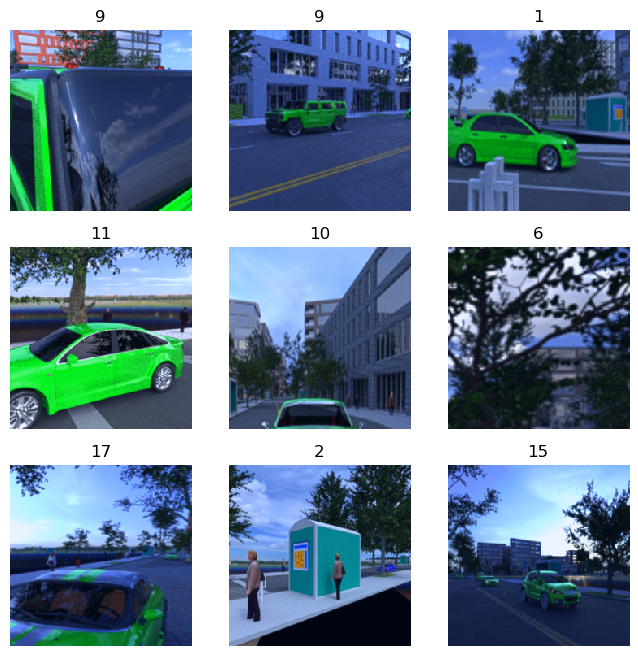

In [48]:
import random
import matplotlib.pyplot as plt
import numpy as np


phase = "train"
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, rows*cols + 1):
    idx = random.randrange(0, dset_sizes[phase])
    img, label = dsets[phase][idx]

    # standardize and transform image for pyplot to show
    img = np.transpose(img, (1, 2, 0))
    min, max = torch.min(img), torch.max(img)
    img = (img - min)/(max - min)

    # plot
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, interpolation='nearest')
plt.show()


Simple dataset statistics

In [63]:
for phase in ["train", "val"]:
    counts = dsets[phase].class_counts
    print(phase, f"TOTAL: {sum(counts.values())}")
    for (key, value) in counts.items():
        print(key, value)
    print('='*5)

train TOTAL: 6779
0 588
1 471
2 523
3 635
4 640
5 221
6 279
7 363
8 265
9 324
10 298
11 341
12 291
13 263
14 299
15 258
16 407
17 313
=====
val TOTAL: 1959
0 144
1 156
2 147
3 194
4 206
5 61
6 84
7 123
8 70
9 86
10 71
11 100
12 84
13 79
14 85
15 74
16 110
17 85
=====


Accuracy, Loss on training & validation